In [2]:
import ast 
import daft 
import inspect
import networkx as nx


In [13]:
# Let's explore the members of the 'daft' module
daft_members = inspect.getmembers(daft)

# Print the public members (name, object) pairs
print("Public members of the 'daft' module:")
for name, member in daft_members:
    if not name.startswith("_"):
        print(f"{name}: {type(member)}")


Public members of the 'daft' module:
Catalog: <class 'abc.ABCMeta'>
DataCatalogTable: <class 'type'>
DataCatalogType: <class 'enum.EnumMeta'>
DataFrame: <class 'type'>
DataType: <class 'type'>
Expression: <class 'type'>
Identifier: <class 'abc.ABCMeta'>
ImageFormat: <class 'type'>
ImageMode: <class 'type'>
ResourceRequest: <class 'type'>
Schema: <class 'type'>
Series: <class 'type'>
Session: <class 'type'>
Table: <class 'abc.ABCMeta'>
TimeUnit: <class 'type'>
Window: <class 'type'>
analytics: <class 'module'>
analytics_client: <class 'daft.analytics.AnalyticsClient'>
annotations: <class '__future__._Feature'>
api_annotations: <class 'module'>
arrow_utils: <class 'module'>
attach: <class 'function'>
attach_catalog: <class 'function'>
attach_function: <class 'function'>
attach_table: <class 'function'>
catalog: <class 'module'>
coalesce: <class 'function'>
col: <class 'function'>
context: <class 'module'>
convert: <class 'module'>
create_namespace: <class 'function'>
create_namespace_if_

In [19]:
import inspect
import importlib
from enum import Enum
from typing import Optional, Dict, Any, List, Union
from pydantic import BaseModel, Field
import logging

# Configure logging
logging.basicConfig(level=logging.WARNING) # Set to INFO or DEBUG for more detail
logger = logging.getLogger(__name__)

class NodeType(str, Enum):
    MODULE = "Module"
    CLASS = "Class"
    FUNCTION = "Function"
    METHOD = "Method"
    PROPERTY = "Property"
    BUILTIN = "Builtin"
    OTHER = "Other"

class ApiNode(BaseModel):
    """Represents a node in the API structure (module, class, function, etc.)."""
    name: str
    full_path: str
    node_type: NodeType
    docstring: Optional[str] = None
    signature_str: Optional[str] = None
    source_file: Optional[str] = None
    # Children stores the name and type, enabling incremental exploration
    children: Dict[str, NodeType] = Field(default_factory=dict)

    @classmethod
    def from_object(cls, obj: Any, name: str, full_path: str) -> 'ApiNode':
        """Creates an ApiNode from a Python object."""
        node_type = NodeType.OTHER
        docstring = inspect.getdoc(obj)
        signature_str = None
        source_file = None
        children = {}

        try:
            source_file = inspect.getfile(obj)
        except TypeError:
            # Often happens for built-ins or other non-file objects
            logger.info(f"Could not get source file for {full_path}")
            source_file = "Built-in or C-extension"


        if inspect.ismodule(obj):
            node_type = NodeType.MODULE
        elif inspect.isclass(obj):
            node_type = NodeType.CLASS
        elif inspect.isfunction(obj) or inspect.ismethod(obj):
            # Distinguish between function and method if needed, but Function often suffices
            node_type = NodeType.METHOD if inspect.ismethod(obj) else NodeType.FUNCTION
            try:
                sig = inspect.signature(obj)
                signature_str = str(sig)
            except (ValueError, TypeError):
                 # ValueError: no signature found (e.g., built-in C functions)
                 # TypeError: not a callable type we can inspect (e.g., property)
                 logger.info(f"Could not get signature for {full_path}")
            except Exception as e:
                 logger.warning(f"Unexpected error getting signature for {full_path}: {e}")
        elif inspect.isbuiltin(obj):
             node_type = NodeType.BUILTIN
        elif isinstance(obj, property):
             node_type = NodeType.PROPERTY
        # Add more specific checks if needed (e.g., isgeneratorfunction, iscoroutinefunction)


        # Get children *names* and *types* for incremental exploration
        if hasattr(obj, '__dict__') or inspect.ismodule(obj) or inspect.isclass(obj):
            try:
                for child_name, child_obj in inspect.getmembers(obj):
                     # Optional: Filter out private/special members if desired
                     # if child_name.startswith('_'):
                     #     continue

                     child_type = NodeType.OTHER
                     if inspect.ismodule(child_obj):
                         child_type = NodeType.MODULE
                     elif inspect.isclass(child_obj):
                         child_type = NodeType.CLASS
                     elif inspect.isfunction(child_obj) or inspect.ismethod(child_obj):
                          child_type = NodeType.METHOD if inspect.ismethod(child_obj) else NodeType.FUNCTION
                     elif inspect.isbuiltin(child_obj):
                          child_type = NodeType.BUILTIN
                     elif isinstance(child_obj, property):
                          child_type = NodeType.PROPERTY

                     children[child_name] = child_type
            except Exception as e:
                # Sometimes getmembers fails on specific objects
                logger.warning(f"Could not get members for {full_path}: {e}")


        return cls(
            name=name,
            full_path=full_path,
            node_type=node_type,
            docstring=docstring,
            signature_str=signature_str,
            source_file=source_file,
            children=children
        )



In [20]:
def explore_api(full_path: str) -> Optional[ApiNode]:
    """
    Dynamically imports and inspects an object given its full path.

    Args:
        full_path: The full import path (e.g., "daft.DataFrame", "os.path.join").

    Returns:
        An ApiNode representing the object, or None if not found/inspectable.
    """
    try:
        if '.' in full_path:
            module_path, obj_name = full_path.rsplit('.', 1)
        else:
            # Top-level module case
            module_path = full_path
            obj_name = "" # The object *is* the module

        # Import the base module
        module = importlib.import_module(module_path)

        if not obj_name:
            # We are exploring the module itcls
            target_obj = module
            name = module.__name__.split('.')[-1] # Get the last part of the module name
        else:
            # Get the specific object within the module (or nested class/function)
            target_obj = getattr(module, obj_name)
            name = obj_name

        return ApiNode.from_object(target_obj, name=name, full_path=full_path)

    except ImportError:
        logger.error(f"Could not import module part of path: {module_path}")
        return None
    except AttributeError:
        logger.error(f"Object '{obj_name}' not found in module '{module_path}'")
        return None
    except Exception as e:
        logger.error(f"Failed to explore API path '{full_path}': {e}")
        return None


In [23]:
daft_node = explore_api(daft)
if daft_node:
    print(f"--- Exploring: {daft_node.full_path} ({daft_node.node_type.value}) ---")
    print(f"Docstring: {daft_node.docstring[:100]}...") # Truncated docstring
    print("\nChildren (sample):")
    count = 0
    for name, node_type in daft_node.children.items():
        if not name.startswith('_'): # Show public children
             print(f"  - {name}: {node_type.value}")
             count += 1
        if count >= 5:
            break
    print("...")

ERROR:__main__:Failed to explore API path '<module 'daft' from '/Users/everett-founder/git/vangelis/internal/work/libs/inspector-gadget/.venv/lib/python3.10/site-packages/daft/__init__.py'>': argument of type 'module' is not iterable


In [25]:
select_node = explore_api(daft.DataFrame.select)
if select_node:
    print(f"\n--- Exploring: {select_node.full_path} ({select_node.node_type.value}) ---")
    print(f"Signature: {select_node.signature_str}")
    print(f"Docstring: {select_node.docstring}") # Full docstring for method

ERROR:__main__:Failed to explore API path '<function DataFrame.select at 0x110dda290>': argument of type 'function' is not iterable


In [26]:
src = inspect.getsource(daft.DataFrame)
module_ast = ast.parse(src)

In [29]:
edges = []
for parent in ast.walk(module_ast):
    for child in ast.iter_child_nodes(parent):
        edges.append((id(parent), id(child)))

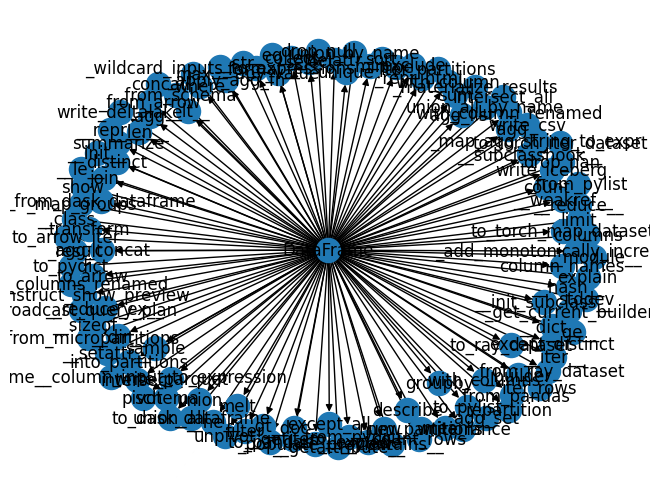

In [32]:
root = explore_api("daft.DataFrame")
G = nx.DiGraph()
for child_name, _ in root.children.items():
    G.add_edge(root.name, child_name)
nx.draw(G, with_labels=True)

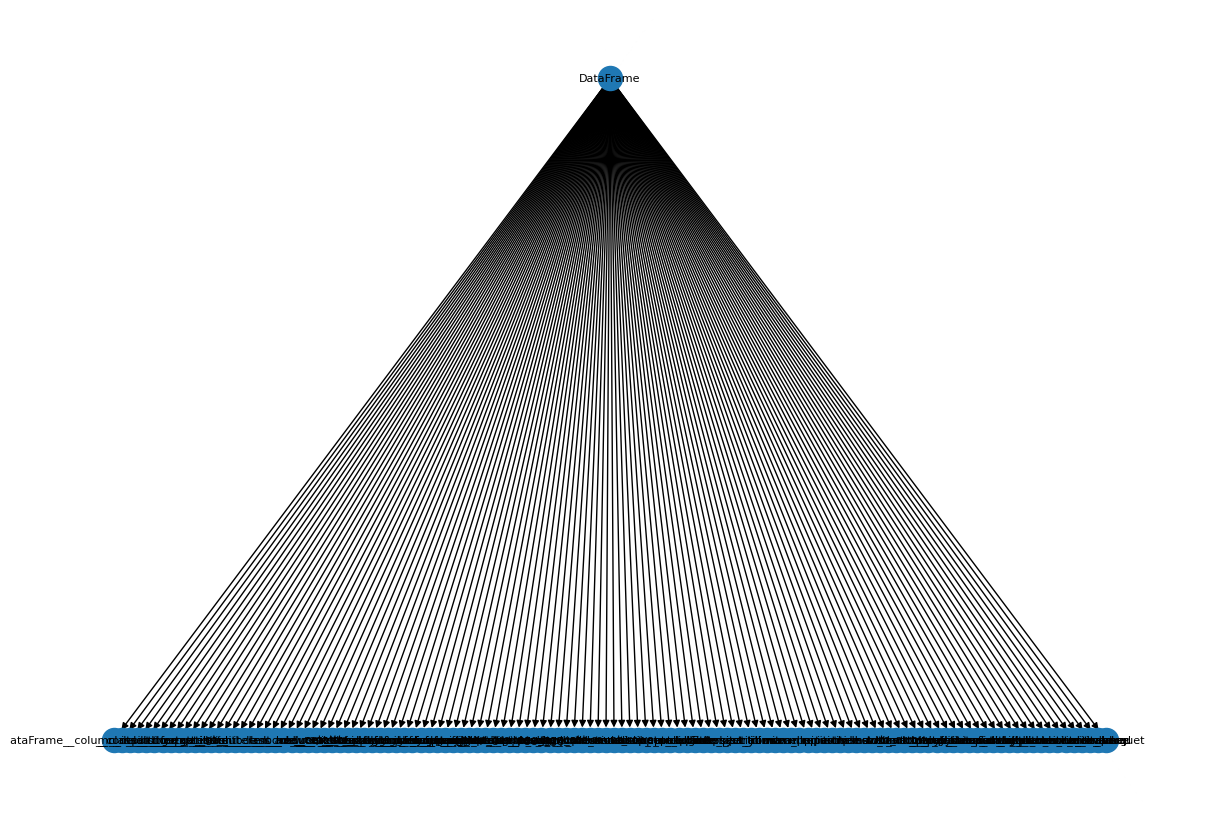

In [34]:
import networkx as nx
import matplotlib.pyplot as plt

# 1) build your ApiNode graph
root = explore_api("daft.DataFrame")

def hierarchy_pos(G, root=None, width=1., vert_gap=0.2, xcenter=0.5):
    """
    If root is None, pick an arbitrary node.
    Returns pos dict: node -> (x,y).
    """
    if root is None:
        root = next(iter(G))
    def _layout(node, left, right, depth, pos):
        pos[node] = ((left + right) / 2, -depth*vert_gap)
        children = list(G.successors(node))
        if not children:
            return
        width_per_child = (right - left) / len(children)
        for i, child in enumerate(children):
            _layout(child,
                    left + i*width_per_child,
                    left + (i+1)*width_per_child,
                    depth+1,
                    pos)
    pos = {}
    _layout(root, 0, width, 0, pos)
    return pos

pos = hierarchy_pos(G, root.name)
plt.figure(figsize=(12, 8))
nx.draw(G, pos, with_labels=True, arrows=True, node_size=300, font_size=8)
plt.show()

In [50]:
# 2) Imports
import logging
from typing import Optional
import os

import importlib
import inspect
from pydantic import BaseModel, Field
from enum import Enum

from langchain.agents import Tool, initialize_agent, AgentType
from langchain.chat_models import ChatOpenAI

# -----------------------------------------------------------------------------
# 3) Your existing ApiNode / explore_api code goes here
#    (you can cut-n-paste it, or import it if you’ve factored it into a .py)
# -----------------------------------------------------------------------------
class NodeType(str, Enum):
    MODULE   = "Module"
    CLASS    = "Class"
    FUNCTION = "Function"
    METHOD   = "Method"
    PROPERTY = "Property"
    BUILTIN  = "Builtin"
    OTHER    = "Other"

class ApiNode(BaseModel):
    name: str
    full_path: str
    node_type: NodeType
    docstring: Optional[str] = None
    signature_str: Optional[str] = None
    signature_grammar: Optional[str] = None
    source_file: Optional[str] = None
    children: dict[str,NodeType] = Field(default_factory=dict)

    @staticmethod
    def classify_object(obj):
        try:
            if inspect.ismodule(obj):     
                node_type = NodeType.MODULE
            elif inspect.isclass(obj):    
                node_type = NodeType.CLASS
            elif inspect.isfunction(obj) or inspect.ismethod(obj):
                node_type = NodeType.METHOD if inspect.ismethod(obj) else NodeType.FUNCTION
                sig = str(inspect.signature(obj))
            elif inspect.isbuiltin(obj):  
                node_type = NodeType.BUILTIN
            elif isinstance(obj, property): 
                node_type = NodeType.PROPERTY
            else:
                node_type = NodeType.OTHER
        except Exception as e:
            raise e
        return node_type

    @classmethod
    def from_object(cls, obj, name, full_path):
        doc = inspect.getdoc(obj)
        node_type = cls.classify_object(obj)
        sig = str(inspect.signature(obj))

        if hasattr(obj, "__dict__") or node_type == NodeType.MODULE or node_type == NodeType.CLASS:
            children = {}
            for child_name, child_obj in inspect.getmembers(obj):
                children[child_name] = cls.classify_object(child_obj)

        return cls(
            name=name,
            full_path=full_path,
            node_type=node_type,
            docstring=doc,
            signature_str=sig,
            source_file=(inspect.getfile(obj) if hasattr(obj, "__file__") else None),
            children=children,
        )


class AgentTraversalOptions(BaseModel):
    """Navigation options for the agent following the initial api node construction."""

    orientation_prompt = """
    <INSPECTOR-GADGET-INIT> 
    You have activated Inspector-Gadget. \n
    A Python Object Introspection tool meant to help you traverse and understand the API of the Python program you are interacting with. \n
    The purpose of Inspector-Gadget is to equip you with the ability to generate code that adheres to the class, method, or function signatures of the Python program request the user originally provided you with. \n

    Inspector-Gadget buids jsonl files that contain the results of your exploration with the following schema: 
    
    ```python
    from pydantic import Field
    from lancedb.pydantic import LanceModel
    from enum import Enum
    from typing import Optional

    class NodeType(str, Enum):
        MODULE   = "Module"
        CLASS    = "Class"
        FUNCTION = "Function"
        METHOD   = "Method"
        PROPERTY = "Property"
        BUILTIN  = "Builtin"
        OTHER    = "Other"

    class ApiNode(LanceModel):
        name: str
        full_path: str
        node_type: NodeType
        docstring: Optional[str] = None
        signature_str: Optional[str] = None
        source_file: Optional[str] = None
        source_module_name: Optional[str] = None
        source_module_release_version: Optional[str] = None
        children: dict[str,NodeType] = Field(default_factory=dict)

    class Gadget(LanceModel): 
        module_name: str
        module_release_version: str
        api_nodes: list[ApiNode]       # List of ApiNodes explored by the tool
        composite_grammar: str         # Constructed from requested api nodes
    ```

    The full lifecycle of an Inspector-Gadget tool call is as follows:
    1. The user will provide you with a path to an object in the Python program you are interacting with.
    2. You will use Inspector-Gadget to explore the API of the given object.
    3. Inspector-Gadget will maintain the results of your exploration as you traverse the API, gradually building a structured, queryable, and searchable catalog of the API.\n
    4. You will then need to identify which elements of the API are relevant to the user's request, and supply a generous estimate of the necessary elements needed to complete your original task.\n
    5. We accomplish this by nesting tool calls following your initial intatiation of Inspector-Gadget. \n 
    6. Once you have identified the necessary elements, a list of tool calls will be returned to you representing structured generation requests using context free grammars. \n 
    7. These tools are for you to use at your discretion. Inspector-Gadget is not a replacement for your own knowledge and expertise, but rather a utility for python code generation and introspection. \n
    8. It can be useful to think of Inspector-Gadget as an arbitrary python auto-coder.\n
    \n
    If you ever need to reset the state of Inspector-Gadget, you can do so by calling the reset option in the main menu. \n
    Inspector-Gadget also works on itself, so that you can understnad how I work. \n
    You can do this from the main menu option `Introspect Inspector-Gadget`. \n
    \n
    Happy inspecting!\n
    </INSPECTOR-GADGET-INIT>
    """
    agent_menu_prompt = """<INSPECTOR-GADGET-MENU>
    Object Path Target: {full_path} \n
    Target_Type: {target_type} \n
    Existing Gadgets: {existing_gadgets} \n
    Gadgets_Discovered_this_session: {gadgets_discovered_this_session} \n
    
    Main Menu: 
        Inspection Options: 
        D1) Inspect path target (default)\n
        D2) Inspect path target sibling \n
        D3) Inspect path target parent \n
        D4) Inspect a path target child \n

        Query Options: 
        Q1) Get Gadget Table Schema \n
        Q2) Query Gadget Table with tool signature \n
        Q3) Query Gadget Table with SQL \n
        Q4) Query Gadget Table with Full Text Search \n
        - Perform a BFS search of a path (Requires exploration, persistance, and indexing of the API structure)\n
        - Explore a path sideways (e.g. to a sibling node) \n
        - Explore a path upwards (e.g. to a parent node) \n
        - Exit Inspector-Gadget.\n

        Other Options: 
        w) Use `inspect` directly. 
        x) Use `ast` directly.  
        y) Introspect Inspector-Gadget. 
        z) Reset Inspector-Gadget. 
                                    
    </INSPECTOR-GADGET-MENU>
    """
    def __init__

    def agent_menu(self):
        

def explore_api(full_path: str) -> Optional[ApiNode]:
    """Dynamically import & inspect."""
    try:
        if "." in full_path:
            module_path, obj_name = full_path.rsplit(".", 1)
        else:
            module_path, obj_name = full_path, ""
        module = importlib.import_module(module_path)
        target = getattr(module, obj_name) if obj_name else module
        name   = obj_name or module.__name__.split(".")[-1]
        return ApiNode.from_object(target, name=name, full_path=full_path)
    except Exception as e:
        return e
    

# -----------------------------------------------------------------------------
# 4) Wrap Inspector-Gadget as a Tool with compatibility methods for LangChain
# -----------------------------------------------------------------------------
def _tool(full_path: str) -> str:
    node = explore_api(full_path)
    if node is ModuleNotFoundError:
        return f"❌ Nothing found at path `{full_path}`"
    # send back a JSON-style dump for readability
    return node.model_dump_json(indent=2)

tool = Tool(
    name="explore_api",
    func=_tool,
    description=(
        "Use this to inspect a Python module/class/function.  "
        "Input = full import path, e.g. 'os.path.join' or 'daft.DataFrame'."
    ),
)


SyntaxError: unmatched ')' (247064807.py, line 117)

In [48]:

# -----------------------------------------------------------------------------
# 5) Spin up the OpenAI + Agent
# -----------------------------------------------------------------------------
llm = ChatOpenAI(api_key=os.getenv("OPENAI_API_KEY"), model="gpt-4.1-mini", temperature=0.7, verbose=True)  # set verbose on LLM if you like

agent = initialize_agent(
    tools=[tool],
    llm=llm,
    agent=AgentType.OPENAI_FUNCTIONS,
    verbose=True,      # <— this prints every thought / tool call / result
)

# -----------------------------------------------------------------------------
# 6) Try it out!
# -----------------------------------------------------------------------------
# Replace this with any prompt you like:
response = agent.run("Explore `daft` and tell me if `df = daft.from_pylist([1, 2, 3])` is a valid operation.")
print(response)



> Entering new AgentExecutor chain...

Invoking: `explore_api` with `daft`


{
  "name": "daft",
  "full_path": "daft",
  "node_type": "Module",
  "docstring": null,
  "signature_str": null,
  "source_file": "/Users/everett-founder/git/vangelis/internal/work/libs/inspector-gadget/.venv/lib/python3.10/site-packages/daft/__init__.py",
  "children": {
    "Catalog": "Class",
    "DataCatalogTable": "Class",
    "DataCatalogType": "Class",
    "DataFrame": "Class",
    "DataType": "Class",
    "Expression": "Class",
    "Identifier": "Class",
    "ImageFormat": "Class",
    "ImageMode": "Class",
    "ResourceRequest": "Class",
    "Schema": "Class",
    "Series": "Class",
    "Session": "Class",
    "Table": "Class",
    "TimeUnit": "Class",
    "Window": "Class",
    "__all__": "Other",
    "__builtins__": "Other",
    "__cached__": "Other",
    "__doc__": "Other",
    "__file__": "Other",
    "__loader__": "Other",
    "__name__": "Other",
    "__package__": "Other",
    "__path__": "O